In [19]:
import pendulum

import geopandas as gpd
from google.cloud import storage
import gcsfs

import seaborn as sns
import os

import numpy as np
import pandas as pd
import osmnx

from scipy import stats

import fiona
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans

In [20]:
#!pip install pendulum
# !pip install google-cloud
# !pip install google-cloud-vision
#!pip install --upgrade google-cloud-storage
#!pip install gcsfs

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import os, time, math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, cross_validate

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [22]:
# Helper Function
def rmse(predictions, targets, **kwargs):
    return np.sqrt(mean_squared_error(targets, predictions))


def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
# src: https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn


def mean_absolute_percentage_error(y_true, y_pred, **kwargs):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Create a custom scorer based on MAPE. This is used in GridSearchCV. Also
# used in sklearn, since that package does not offer MAPE as a scorer.
MAPE_SCORER = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
MAE_SCORER = make_scorer(mean_absolute_error, greater_is_better=False)
RMSE_SCORER = make_scorer(rmse, greater_is_better=False)
MSE_SCORER = make_scorer(mean_squared_error, greater_is_better=False)
R2_SCORER = make_scorer(r2_score, greater_is_better=True)

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [42]:
# read the indices
ind=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/Updated_indices.csv')
ind.head()

,Unnamed: 0.1,ID,year,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,...,state,country,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,0,671,2016,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,California,United States,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN
1,1,671,2017,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,1.020619,...,California,United States,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN
2,2,671,2018,1.352564,0.710009,0.863646,0.291176,2.966061,0.295405,1.433566,...,California,United States,0,308723101,215845474,4890.0,260.0,4630.0,0.053170,0.946830
3,3,671,2019,1.435644,0.660785,0.820369,0.340759,2.407476,0.354620,1.210702,...,California,United States,0,308723101,215845474,4625.0,255.0,4370.0,0.055135,0.944865
4,4,1127,2016,2.222222,0.257277,2.050485,0.584499,3.508108,0.736655,2.235149,...,California,United States,1,308779961,87297166,NaN,NaN,NaN,NaN,NaN


In [43]:
count_sites=ind

In [44]:
# Use Dr. Frank Code to get population density for each location of the counter within buffer
count_sites['geometry'] = gpd.points_from_xy(count_sites.longitude, count_sites.latitude)

count_sites = gpd.GeoDataFrame(count_sites, geometry='geometry', crs='EPSG:4326')

In [45]:
# project the data for geographic analysis
count_sites = count_sites.to_crs(3310)

In [46]:
#read Block group
block_groups_CA = gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_060_blck_grp_2019/CA_blck_grp_2019.shp')
block_groups_Ne=  gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_320_blck_grp_2019/NV_blck_grp_2019.shp')
block_groups=pd.concat([block_groups_CA,block_groups_Ne],axis=0).set_index('GEOID')
block_groups['aland_sqmi'] = block_groups['ALAND'] / (1609.*1609.)
block_groups.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,aland_sqmi
GEOID,,,,,,,,,,,,,,,,
060014001001,G06000104001001,06,001,400100,1,Block Group 1,G5030,S,6894339.0,0.0,+37.8676275,-122.2319460,14302.721555,6.894335e+06,"POLYGON ((-2255602.272 353149.335, -2255597.39...",2.663058
060014002001,G06000104002001,06,001,400200,1,Block Group 1,G5030,S,288069.0,0.0,+37.8497451,-122.2488478,2971.010308,2.880696e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81...",0.111272
060014002002,G06000104002002,06,001,400200,2,Block Group 2,G5030,S,298490.0,0.0,+37.8465865,-122.2503095,3162.343955,2.984887e+05,"POLYGON ((-2258439.130 352894.146, -2258619.65...",0.115297
060014003001,G06000104003001,06,001,400300,1,Block Group 1,G5030,S,265695.0,0.0,+37.8439848,-122.2486668,2553.074982,2.656948e+05,"POLYGON ((-2258662.984 352641.307, -2258755.16...",0.102629
060014003002,G06000104003002,06,001,400300,2,Block Group 2,G5030,S,269347.0,0.0,+37.8362550,-122.2516875,3534.834596,2.693459e+05,"POLYGON ((-2259955.644 352133.337, -2259945.80...",0.104040


In [47]:
block_groups.columns

Index(['GISJOIN', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape_Leng', 'Shape_Area', 'geometry', 'aland_sqmi'],
      dtype='object')

In [48]:
block_groups.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [49]:
bg_pop = pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/pop/nhgis0102_csv/nhgis0102_ds244_20195_blck_grp.csv')
bg_pop['geoid'] = bg_pop['GEOID'].str[7:]
bg_pop = bg_pop.set_index('geoid')
bg_pop = bg_pop.rename(columns={'ALUBE001': 'pop'})
bg_pop.head()

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,SDUNIA,PCI,PUMAA,GEOID,BTTRA,BTBGA,NAME_E,pop,NAME_M,ALUBM001
geoid,,,,,,,,,,,,,,,,,,,,,
060014001001,G06000104001001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014001001,NaN,NaN,"Block Group 1, Census Tract 4001, Alameda Coun...",3120,"Block Group 1, Census Tract 4001, Alameda Coun...",208
060014002001,G06000104002001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002001,NaN,NaN,"Block Group 1, Census Tract 4002, Alameda Coun...",990,"Block Group 1, Census Tract 4002, Alameda Coun...",138
060014002002,G06000104002002,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002002,NaN,NaN,"Block Group 2, Census Tract 4002, Alameda Coun...",1017,"Block Group 2, Census Tract 4002, Alameda Coun...",123
060014003001,G06000104003001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014003001,NaN,NaN,"Block Group 1, Census Tract 4003, Alameda Coun...",1134,"Block Group 1, Census Tract 4003, Alameda Coun...",238
060014003002,G06000104003002,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014003002,NaN,NaN,"Block Group 2, Census Tract 4003, Alameda Coun...",1237,"Block Group 2, Census Tract 4003, Alameda Coun...",263


In [50]:
block_groups = block_groups.join(bg_pop[['pop']])

In [51]:
# calculate area-weightd average population density - make this a function if needed
count_sites = count_sites.set_index(['ID', 'year'])

block_groups['popden'] = block_groups['pop']/block_groups['aland_sqmi']
block_groups = block_groups.to_crs(3310)

count_sites['buffer_geometry'] = count_sites.buffer(1609.)
count_sites = count_sites.set_geometry('buffer_geometry')

joined_geos = count_sites[['buffer_geometry']].\
    sjoin(block_groups[['geometry']]).\
    join(block_groups[['geometry']], on='index_right')

joined_geos['overlap'] = joined_geos['buffer_geometry'].intersection(joined_geos['geometry']).area

joined_geos['overlap_ratio'] = joined_geos['overlap']/(joined_geos['buffer_geometry'].area)

joined_geos = joined_geos.join(block_groups[['popden']], on='index_right')

joined_geos['weighted_popden'] = joined_geos['overlap_ratio'] * joined_geos['popden']

count_sites['popden'] = joined_geos.groupby(['ID', 'year'])['weighted_popden'].sum()

In [52]:
count_sites = count_sites.set_geometry('geometry').drop(columns='buffer_geometry')

In [53]:
count_sites.columns

Index(['Unnamed: 0.1', 'Max_WWI', 'Average_WWI', 'Weekday_Aergage_AMI',
       'Weekend_Aergage_AMI', 'Average AMI_wday_wend', 'Max_weekend_AMI',
       'Max_weekday_AMI', 'Daily_Max_AMI', 'Daily_Max_PMI',
       'Weekday_Aergage_PMI', 'Weekend_Aergage_PMI', 'Average PMI_wday_wend',
       'Max_weekday_PMI', 'Max_weekend_PMI', 'max_daily_am_pm',
       'max_daily_am/pm_value', 'max_weekend_am/pm', 'max_weekend_am_pm_Value',
       'max_weekday_am/pm', 'max_weekday_am_pm_value', 'seasonal_factor',
       'latitude', 'longitude', 'location', 'road', 'city', 'county', 'state',
       'country', 'Unnamed: 0', 'edgeUID', 'osmId', 'stv_total',
       'stv_com_total', 'stv_rec_total', 'stv_com_ratio', 'stv_rec_ratio',
       'geometry', 'popden'],
      dtype='object')

<AxesSubplot:xlabel='popden', ylabel='Average_WWI'>

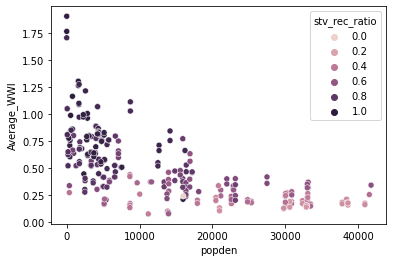

In [54]:
sns.scatterplot(data=count_sites[count_sites.Average_WWI < 10], x='popden', y='Average_WWI', hue='stv_rec_ratio')

<AxesSubplot:xlabel='popden', ylabel='max_weekday_am_pm_value'>

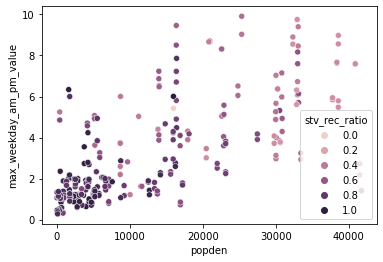

In [55]:
# weekday Pattern
sns.scatterplot(data=count_sites[count_sites.max_weekday_am_pm_value < 10], x='popden', y='max_weekday_am_pm_value', hue='stv_rec_ratio')

<AxesSubplot:xlabel='popden', ylabel='max_weekend_am_pm_Value'>

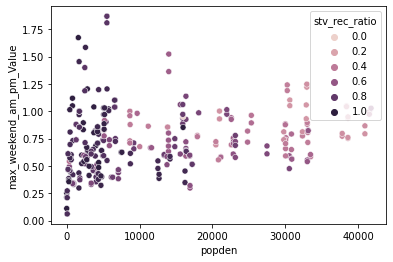

In [56]:
# weekend Pattern
sns.scatterplot(data=count_sites[count_sites.max_weekend_am_pm_Value< 3], x='popden', y='max_weekend_am_pm_Value', hue='stv_rec_ratio')

In [57]:
count_sites.shape

(595, 40)

In [58]:
count_sites = count_sites.reset_index(level=0)
count_sites = count_sites.reset_index(level=0)

In [59]:
count_sites.head()

,year,ID,Unnamed: 0.1,Max_WWI,Average_WWI,Weekday_Aergage_AMI,Weekend_Aergage_AMI,Average AMI_wday_wend,Max_weekend_AMI,Max_weekday_AMI,...,Unnamed: 0,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,popden
0,2016,671,0,2.232143,0.769600,0.703185,0.324525,2.166812,0.360694,0.930693,...,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN,POINT (-216265.861 -22230.259),12677.958400
1,2017,671,1,2.893617,0.776723,0.743791,0.376689,1.974549,0.437975,1.020619,...,0,308723101,215845474,NaN,NaN,NaN,NaN,NaN,POINT (-216265.861 -22230.259),12677.958400
2,2018,671,2,1.352564,0.710009,0.863646,0.291176,2.966061,0.295405,1.433566,...,0,308723101,215845474,4890.0,260.0,4630.0,0.053170,0.946830,POINT (-216265.861 -22230.259),12677.958400
3,2019,671,3,1.435644,0.660785,0.820369,0.340759,2.407476,0.354620,1.210702,...,0,308723101,215845474,4625.0,255.0,4370.0,0.055135,0.944865,POINT (-216265.861 -22230.259),12677.958400
4,2016,1127,4,2.222222,0.257277,2.050485,0.584499,3.508108,0.736655,2.235149,...,1,308779961,87297166,NaN,NaN,NaN,NaN,NaN,POINT (-212739.517 -21764.447),41734.239831


# Develop the 10 fold CV Linear Regression model

In [60]:
def ln_model(X, Y):
    # Now we do 10fold cv without library
    num_folds = 10
    kfold = KFold(n_splits=10, shuffle=True, random_state=1)

    # Now we perform KFold:

    fold_num = 1
    lr_MAPE_train = []
    lr_MAPE_scores = []
    lr_RMSE_train = []
    lr_RMSE_scores = []
    lr_MAE_train = []
    lr_MAE_scores = []
    lr_R2_train = []
    lr_R2_scores = []
    test_pred = []
    # we split the entire dataframe:
    for train, test in kfold.split(X, Y):
        lr_CV_model = LinearRegression().fit(X[train], Y[train])
        train_predictions = lr_CV_model.predict(X[train])
        test_predictions = lr_CV_model.predict(X[test])
        predictions_df=dataset = pd.DataFrame(np.hstack((lr_CV_model.predict(X[test]), Y[test].reshape(-1, 1))))
        train_mape = mean_absolute_percentage_error(Y[train], train_predictions)
        lr_MAPE_train.append(train_mape)
        test_mape = mean_absolute_percentage_error(Y[test], test_predictions)
        lr_MAPE_scores.append(test_mape)
        train_rmse = math.sqrt(mean_squared_error(Y[train], train_predictions))
        lr_RMSE_train.append(train_rmse)
        test_rmse = math.sqrt(mean_squared_error(Y[test], test_predictions))
        lr_RMSE_scores.append(test_rmse)
        train_mae = mean_absolute_error(Y[train], train_predictions)
        lr_MAE_train.append(train_mae)
        test_mae = mean_absolute_error(Y[test], test_predictions)
        lr_MAE_scores.append(test_mae)
        train_r2 = r2_score(Y[train], train_predictions)
        lr_R2_train.append(train_r2)
        score_r2 = r2_score(Y[test], test_predictions)
        lr_R2_scores.append(score_r2)
        test_pred.append(predictions_df)
        appended_data=pd.concat(test_pred)
        print(
            f"------------------------------------------Fold {fold_num}------------------------------------------")
        print(f"\tTrain MAE: {train_mae}\tScore Loss: {test_mae}")
        print(f"\tTrain RMSE: {train_rmse}\tScore RMSE: {test_rmse}")
        print(f"\tTrain MAPE: {train_mape}\tScore MAPE: {test_mape}")
        print(f"\tTrain R2:   {train_r2}\tScore R2: {score_r2}")
        fold_num += 1

    print(f"\n\nOverall MAE: {np.mean(lr_MAE_scores)} +/- {np.std(lr_MAE_scores)}")
    print(f"Overall RMSE: {np.mean(lr_RMSE_scores)} +/- {np.std(lr_RMSE_scores)}")
    print(f"Overall MAPE: {np.mean(lr_MAPE_scores)} +/- {np.std(lr_MAPE_scores)}")
    print(f"Overall R2: {np.mean(lr_R2_scores)} +/- {np.std(lr_R2_scores)}\n\n")

    print("Delimited table for linear Regression 10 fold:")
    print("MAPE\tRMSE\tMAE\tR2")
    for i in range(0, 10):
        print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f" %
              (lr_MAPE_train[i], lr_MAPE_scores[i], lr_RMSE_train[i], lr_RMSE_scores[i], lr_MAE_train[i], lr_MAE_scores[i], lr_R2_train[i], lr_R2_scores[i]))
    print("%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t%.2f/%.2f\t<===Averages" % (np.mean(lr_MAPE_train), np.mean(lr_MAPE_scores), np.mean(lr_RMSE_train),
          np.mean(lr_RMSE_scores), np.mean(lr_MAE_train), np.mean(lr_MAE_scores), np.mean(lr_R2_train), np.mean(lr_R2_scores)))
    print(f"lr_rf_fs_CV_model.coef_ ==\n{lr_CV_model.coef_}")
    print(f"\nlr_rf_fs_CV_model.intercept_ == {lr_CV_model.intercept_}")
    appended_data.to_csv('appended_data.csv',index=False)

In [61]:
data=count_sites.loc[count_sites['Average_WWI'] < 1.5]
data1=data[(data.year==2018)|(data.year==2019)]
X_data=data1[['popden','stv_rec_ratio']]
Y_data=data1[['Average_WWI']]

In [62]:
scoring = {'mean_absolute_error': MAE_SCORER,
           'mean_squared_error': MSE_SCORER,
           'r2': R2_SCORER,
           'mean_absolute_percentage_error': MAPE_SCORER}

In [63]:
# # use the Sklearn library to run linear regression model
# lm = LinearRegression()
# # create a KFold object with 5 splits 
# folds = KFold(n_splits = 10, shuffle = True, random_state = 1)
# scores = cross_validate(lm, X_data, Y_data, cv=5,
#                         scoring=scoring, return_train_score=True)
# sorted(scores.keys())

In [64]:
# print(
#     f"Training MAPE:  {(-scores['train_mean_absolute_percentage_error']).mean()}\tTesting MAPE: {(-scores['test_mean_absolute_percentage_error']).mean()}")
# print(
#     f"Training RMSE: {(np.sqrt(-scores['train_mean_squared_error'])).mean()}\tTesting RMSE: {(np.sqrt(-scores['test_mean_squared_error'])).mean()}")
# print(
#     f"Training MAE:  {(-scores['train_mean_absolute_error']).mean()}\tTesting MAE: {(-scores['test_mean_absolute_error']).mean()}")
# print(
#     f"Training R2:   {(scores['train_r2']).mean()}\tTesting R2: {(scores['test_r2']).mean()}")



## Now Develop the Model WWI Vs Popden and Strava rectational ratio for weekday

In [65]:
X = np.asarray(X_data)
Y = np.asarray(Y_data)

In [66]:
ln_model(X, Y)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 0.12441328461232554	Score Loss: 0.15400063264852965
	Train RMSE: 0.16214204220011905	Score RMSE: 0.21940179217039774
	Train MAPE: 35.80672255446953	Score MAPE: 32.19686219099967
	Train R2:   0.6420247751224524	Score R2: 0.5603906804593752
------------------------------------------Fold 2------------------------------------------
	Train MAE: 0.12730525926908628	Score Loss: 0.13764940800186015
	Train RMSE: 0.16944355638030467	Score RMSE: 0.1644643187429745
	Train MAPE: 37.19844746823261	Score MAPE: 32.53512984622604
	Train R2:   0.6540139555192097	Score R2: 0.2076991305390895
------------------------------------------Fold 3------------------------------------------
	Train MAE: 0.12561555231587776	Score Loss: 0.14561987288295078
	Train RMSE: 0.16729945923320277	Score RMSE: 0.1812380142542464
	Train MAPE: 35.83710862998395	Score MAPE: 35.277832241242315
	Train R2:   0.6315200300916805	Scor

In [122]:
# plot the observation and Prediction

In [67]:
appended_data=pd.read_csv('appended_data.csv')
appended_data1=appended_data.rename(columns={'0':'Predicted WWI','1':'Observed WWI'})
appended_data1.head()

,Predicted WWI,Observed WWI
0,0.743376,1.304704
1,0.700775,1.275093
2,0.590947,0.203501
3,0.419769,0.369573
4,0.622230,0.773080


In [68]:
appended_data1['Observed WWI'].max()

1.30470404

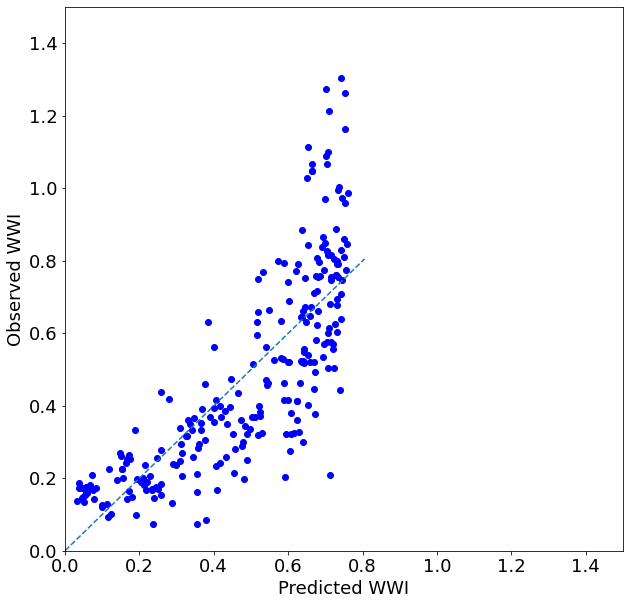

In [69]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted WWI', 'Observed WWI', data=appended_data1, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted WWI', fontsize=18)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed WWI', fontsize=18)
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Now Develop the Model Max am_pm Vs Popden and Strava rectational ratio for weekday

In [70]:
data2=data1.loc[data1['max_weekday_am_pm_value'] < 10]
X1=np.asarray(data2[['popden','stv_rec_ratio']])
Y1=np.asarray(data2[['max_weekday_am_pm_value']])

In [71]:
Y1.shape

(251, 1)

In [72]:
ln_model(X1, Y1)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 1.11451732350517	Score Loss: 1.4621405314025953
	Train RMSE: 1.5459216517274372	Score RMSE: 2.184031000154152
	Train MAPE: 48.60145152982173	Score MAPE: 70.94422141294478
	Train R2:   0.6052333460097791	Score R2: 0.1659942106378417
------------------------------------------Fold 2------------------------------------------
	Train MAE: 1.1994381420510833	Score Loss: 0.7937977619522976
	Train RMSE: 1.6716162645957444	Score RMSE: 1.035985410864217
	Train MAPE: 54.29744327228955	Score MAPE: 33.370865872318035
	Train R2:   0.5632646312484031	Score R2: 0.46490898507780043
------------------------------------------Fold 3------------------------------------------
	Train MAE: 1.1521384557539764	Score Loss: 1.4724568025801381
	Train RMSE: 1.5817778233508444	Score RMSE: 1.9619637944566892
	Train MAPE: 52.1612144838549	Score MAPE: 82.94630912371817
	Train R2:   0.579378931542757	Score R2: 0.4113368

In [73]:
appended_data=pd.read_csv('appended_data.csv')
appended_data2=appended_data.rename(columns={'0':'Predicted Max AMIPMI','1':'Observed Max AMIPMI'})
appended_data2.head()

,Predicted Max AMIPMI,Observed Max AMIPMI
0,1.036122,6.337662
1,1.263187,2.175644
2,2.113322,2.333333
3,1.846414,1.777344
4,7.038386,2.175495


In [74]:
appended_data2['Predicted Max AMIPMI'].max()

7.676623457035315

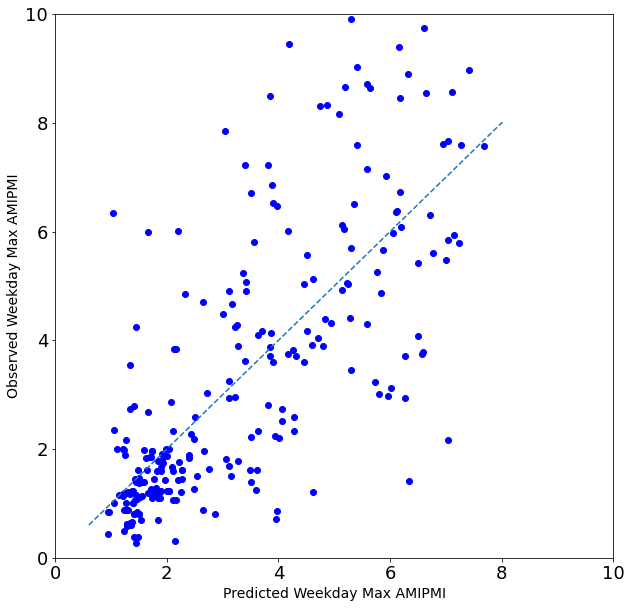

In [75]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted Max AMIPMI', 'Observed Max AMIPMI', data=appended_data2, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted Weekday Max AMIPMI', fontsize=14)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed Weekday Max AMIPMI', fontsize=14)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Now Develop the Model Max am_pm Vs Popden and Strava rectational ratio for weekend

In [76]:
data3=data1.loc[data1['max_weekend_am_pm_Value'] < 10]
X2=np.asarray(data3[['popden','stv_rec_ratio']])
Y2=np.asarray(data3[['max_weekend_am_pm_Value']])

In [77]:
ln_model(X2, Y2)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 0.25100490262171554	Score Loss: 0.2645989171131574
	Train RMSE: 0.49413389607073144	Score RMSE: 0.3613683657915816
	Train MAPE: 44.10036152007425	Score MAPE: 40.32441890104547
	Train R2:   0.0021442525780550614	Score R2: 0.0023411518292876243
------------------------------------------Fold 2------------------------------------------
	Train MAE: 0.25367555996136115	Score Loss: 0.22871855083982312
	Train RMSE: 0.4981131943289842	Score RMSE: 0.31005370127480575
	Train MAPE: 44.298976832927714	Score MAPE: 33.59829206453057
	Train R2:   0.002515043175172149	Score R2: -0.007177961424053025
------------------------------------------Fold 3------------------------------------------
	Train MAE: 0.25789255212486517	Score Loss: 0.2196944663832006
	Train RMSE: 0.5011970252539157	Score RMSE: 0.26436647022395143
	Train MAPE: 44.735176196606865	Score MAPE: 40.07105005765851
	Train R2:   0.001094009687

In [78]:
appended_data=pd.read_csv('appended_data.csv')
appended_data2=appended_data.rename(columns={'0':'Predicted Max AMIPMI','1':'Observed Max AMIPMI'})
appended_data2.head()

,Predicted Max AMIPMI,Observed Max AMIPMI
0,0.750492,1.674200
1,0.755392,0.969743
2,0.767149,0.902439
3,0.763882,0.354236
4,0.809439,1.189707


In [79]:
appended_data2['Observed Max AMIPMI'].max()

6.0

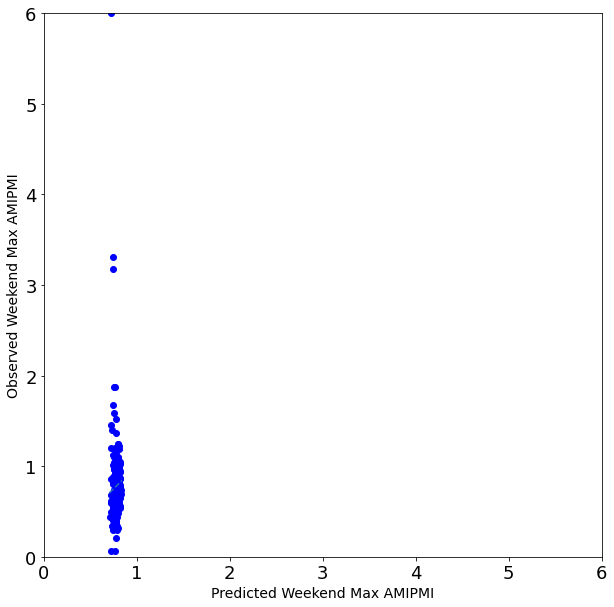

In [80]:
# Plot Observed Vs Predicted WWI
plt.figure(figsize=(10,10)) # Specify size of the chart
plt.scatter('Predicted Max AMIPMI', 'Observed Max AMIPMI', data=appended_data2, marker = 'o', c = 'blue')
abline(1, (0,0))
#plt.legend(('abline'), title='Legend',loc=1,prop={"size":18}, fancybox=True)
plt.xlabel('Predicted Weekend Max AMIPMI', fontsize=14)
#prop={"size":18}, 
#fontsize=20,
plt.ylabel('Observed Weekend Max AMIPMI', fontsize=14)
plt.xlim(0,6)
plt.ylim(0,6)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Develop model AMI VS MPI


In [86]:
data3=data1.loc[data1['Weekday_Aergage_PMI'] >=0]
X3=np.asarray(data3[['Weekday_Aergage_AMI']])
Y3=np.asarray(data3[['Weekday_Aergage_PMI']])

In [87]:
ln_model(X3, Y3)

------------------------------------------Fold 1------------------------------------------
	Train MAE: 1.526832725158454	Score Loss: 1.5503903985174436
	Train RMSE: 2.134259737926743	Score RMSE: 2.164530463628788
	Train MAPE: 115.64700532349433	Score MAPE: 104.67503277494646
	Train R2:   0.010536197926301782	Score R2: 0.00010301722459138407
------------------------------------------Fold 2------------------------------------------
	Train MAE: 1.6411513319908615	Score Loss: 1.0717518546846196
	Train RMSE: 2.222549990316874	Score RMSE: 1.1863762547727756
	Train MAPE: 123.49062699935097	Score MAPE: 132.38350316548613
	Train R2:   0.008129130455410749	Score R2: -1.8833728687270632
------------------------------------------Fold 3------------------------------------------
	Train MAE: 1.4822692811377147	Score Loss: 1.931251789831638
	Train RMSE: 2.0961889494859425	Score RMSE: 2.4698911580208867
	Train MAPE: 111.3273565287197	Score MAPE: 141.0644641862605
	Train R2:   0.009646331906960293	Score

In [ ]:
# Model does not work

# End of the Idices Prediction